### Title: Predicting Aqueous Solubility of Molecules using Different Machine Learning Methods

This work is based on the research article of John S. Delaney which focuses on the application Linear Regression to predict the solubility of molecules which is an important physiochemical property to consider in drug design and development.

The code is inspired from the following YouTube video (https://www.youtube.com/watch?v=VXFFHHoE1wk&list=PLtqF5YXg7GLlQJUv9XJ3RWdd5VYGwBHrP&index=10)

The following modifications are made in this code:<br>
+ The relationship between X variable and Y is visualized through scatter plots and statistical analyses.<br>
+ Both X and Y are normalized. <br>
+ Apart from multiple linear regression shown in the video, this code also implements other regression techniques including random forest regression, lasso regression, XGBoost regression and support vector regression.<br>
+ The performance of different regression models are compared.

### 1. Download and Read Delaney's Solubility Dataset

The dataset is from the paper entitled ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure
and was downloaded from https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv

In [1]:
import pandas as pd

In [2]:
# read solubility csv as a Pandas data frame
sol_df = pd.read_csv("delaney.csv")

In [3]:
# check the first few rows
sol_df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [4]:
# check the dimension of the data frame
sol_df.shape

(1144, 4)

In [5]:
# check the data type of each variable
sol_df.dtypes

Compound ID                              object
measured log(solubility:mol/L)          float64
ESOL predicted log(solubility:mol/L)    float64
SMILES                                   object
dtype: object

In [6]:
# check for missing values
sol_df.isnull().sum()

Compound ID                             0
measured log(solubility:mol/L)          0
ESOL predicted log(solubility:mol/L)    0
SMILES                                  0
dtype: int64

In [7]:
# examine SMILES feature
sol_df.SMILES[10:30]

10    Clc1cc(Cl)c(Cl)c(Cl)c1
11          Clc1cccc(Cl)c1Cl
12             Cc1cccc(C)c1C
13      Brc1cc(Br)c(Br)cc1Br
14      Clc1cc(Cl)c(Cl)cc1Cl
15          Cc1cc(C)c(C)cc1C
16      c1(Br)c(Br)cc(Br)cc1
17        Clc1ccc(Cl)c(Cl)c1
18           Cc1ccc(C)c(C)c1
19                Oc1ccccc1O
20              Brc1ccccc1Br
21                    BrCCBr
22              Clc1ccccc1Cl
23                    ClCCCl
24                 CC(Cl)CCl
25        FC(F)(Cl)C(F)(F)Cl
26                  CCOCCOCC
27              CCc1ccccc1CC
28    O=N(=O)c1ccccc1N(=O)=O
29                    CC1CO1
Name: SMILES, dtype: object

### 2. Convert SMILES string to RDKIT objects

In [8]:
from rdkit import Chem

In [9]:
# convert objects from SMILES feature into rdkit objects
mol_data = [Chem.MolFromSmiles(element) for element in sol_df.SMILES]

In [10]:
# check the number of elements in mol_data
len(mol_data)

1144

### 3. Calculate Molecular Descriptors
To predict LogS (log of the aqueous solubility), the study by Delaney makes use of 4 molecular descriptors:

+ cLogP (Octanol-water partition coefficient)<br>
+ MW (Molecular weight)<br>
+ RB (Number of rotatable bonds)<br>
+ AP (Aromatic proportion = number of aromatic atoms / total number of heavy atoms)

Rdkit readily computes the first 3. As for the AP descriptor, we will calculate this by manually computing the ratio of the number of aromatic atoms to the total number of heavy atoms which rdkit can compute.

In [11]:
import numpy as np
from rdkit.Chem import Descriptors

### 3.1 Find LogP, MW, RB

In [12]:
# create an empty numpy array
mol_descriptors_np = np.arange(1,1)

# find CLogP, molecular weight and number of rotatable bonds for each rdkit object 
for mol in mol_data:
    clogP = Descriptors.MolLogP(mol)
    mol_weight = Descriptors.MolWt(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    
    row = np.array([clogP, mol_weight, num_rotatable_bonds])
    
    if mol_descriptors_np.size == 0:
        mol_descriptors_np = row
    else:
        mol_descriptors_np = np.vstack([mol_descriptors_np, row])

In [13]:
# check the dimension of the array containing molecular descriptors
mol_descriptors_np.shape

(1144, 3)

### 3.2 Find aromatic proportion

In [14]:
# create an empty np array
aromatic_arr = []

# find aromatic proportion manually
for mol in mol_data:
    total_atoms = mol.GetNumAtoms()
    aromatic_count = 0
    for i in range(total_atoms):
        if mol.GetAtomWithIdx(i).GetIsAromatic():
            aromatic_count += 1
          
    aromatic_arr.append(aromatic_count/Descriptors.HeavyAtomCount(mol))  

In [15]:
# convert aromatic_arr list to numpy array
aromatic_np = np.array(aromatic_arr).reshape(-1,1)
aromatic_np.shape

(1144, 1)

In [16]:
# concat the aromatic proportion values with the rest of the descriptors
all_descriptors_np = np.hstack([mol_descriptors_np, aromatic_np])

In [17]:
# transform the descriptors numpy array into a dataframe
descriptors_df = pd.DataFrame(all_descriptors_np, columns = ['cLogP', 'MolWeight', 'numRotatableBonds','AromaticProportion'])

In [18]:
# concat descriptors df with solubility values of sol_df 
descriptors_df = pd.concat([descriptors_df,sol_df["measured log(solubility:mol/L)"]],axis=1)

In [19]:
# rename measured solubility column
descriptors_df.rename(columns={'measured log(solubility:mol/L)': 'log(solubility:mol/L)'}, inplace=True)

In [20]:
descriptors_df

,cLogP,MolWeight,numRotatableBonds,AromaticProportion,log(solubility:mol/L)
0,2.59540,167.850,0.0,0.000000,-2.180
1,2.37650,133.405,0.0,0.000000,-2.000
2,2.59380,167.850,1.0,0.000000,-1.740
3,2.02890,133.405,1.0,0.000000,-1.480
4,2.91890,187.375,1.0,0.000000,-3.040
...,...,...,...,...,...
1139,1.98820,287.343,8.0,0.000000,1.144
1140,3.42130,286.114,2.0,0.333333,-4.925
1141,3.60960,308.333,4.0,0.695652,-3.893
1142,2.56214,354.815,3.0,0.521739,-3.790


### 4. Exploratory Data Analysis

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### 4.1 Visualize relationship between X and Y

In [22]:
descriptors_df.columns

Index(['cLogP', 'MolWeight', 'numRotatableBonds', 'AromaticProportion',
       'log(solubility:mol/L)'],
      dtype='object')

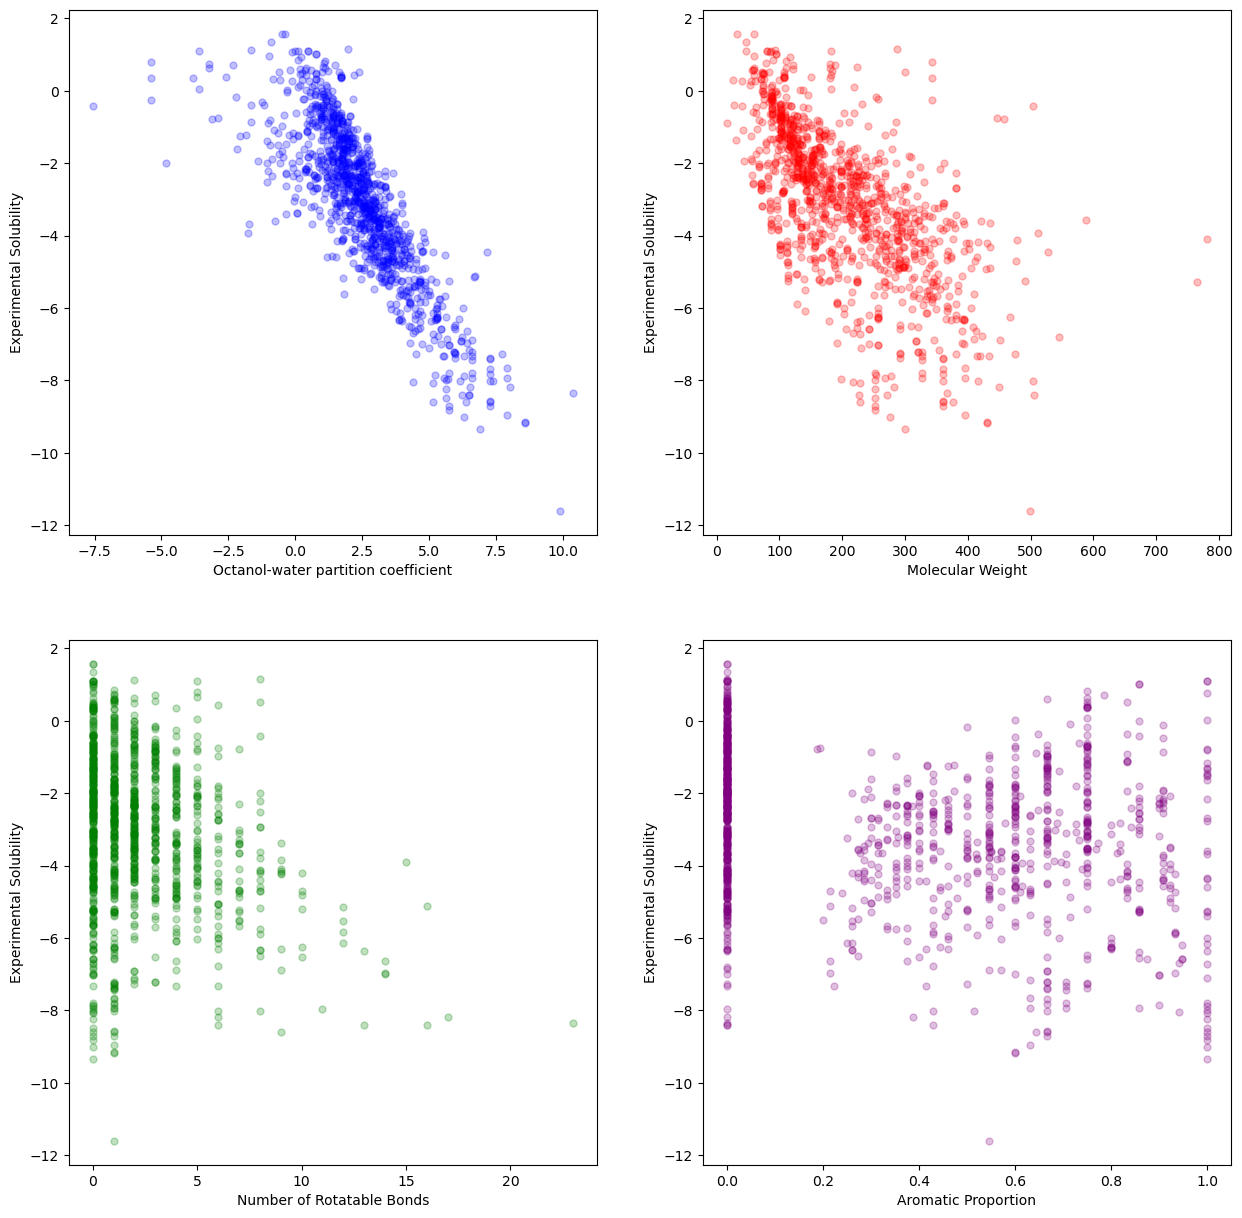

In [23]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.scatter(x=descriptors_df.cLogP, y=descriptors_df[['log(solubility:mol/L)']],color = 'blue',s = 25, alpha = 0.25)
plt.ylabel('Experimental Solubility')
plt.xlabel('Octanol-water partition coefficient')

plt.subplot(2,2,2)
plt.scatter(x=descriptors_df.MolWeight, y=descriptors_df[['log(solubility:mol/L)']],color = 'red',s = 25, alpha = 0.25)
plt.ylabel('Experimental Solubility')
plt.xlabel('Molecular Weight')

plt.subplot(2,2,3)
plt.scatter(x=descriptors_df.numRotatableBonds, y=descriptors_df[['log(solubility:mol/L)']],color = 'green',s = 25, alpha = 0.25)
plt.ylabel('Experimental Solubility')
plt.xlabel('Number of Rotatable Bonds')

plt.subplot(2,2,4)
plt.scatter(x=descriptors_df.AromaticProportion, y=descriptors_df[['log(solubility:mol/L)']],color = 'purple',s = 25, alpha = 0.25)
plt.ylabel('Experimental Solubility')
plt.xlabel('Aromatic Proportion')

plt.show()

### 4.2 Descriptive Statistical Analysis

In [24]:
descriptors_df.describe()

,cLogP,MolWeight,numRotatableBonds,AromaticProportion,log(solubility:mol/L)
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2.449133,204.631675,2.173951,0.364932,-3.057997
std,1.866003,102.620500,2.627398,0.343305,2.096502
min,-7.571400,16.043000,0.000000,0.000000,-11.600000
25%,1.414900,122.126000,0.000000,0.000000,-4.332250
50%,2.340300,183.594500,1.000000,0.375000,-2.870500
75%,3.406475,270.715750,3.000000,0.666667,-1.600000
max,10.388600,780.949000,23.000000,1.000000,1.580000


### 4.3 Correlation analysis

<Axes: >

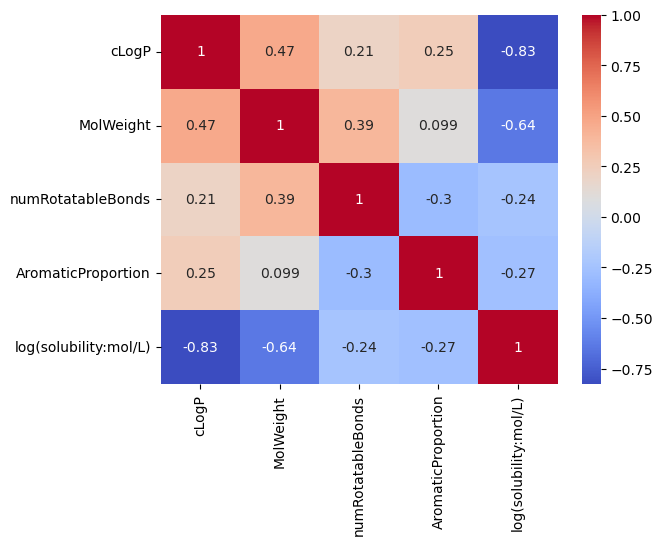

In [25]:
sns.heatmap(descriptors_df.corr(), annot=True, cmap='coolwarm')

### 5. Split Data into X and Y

In [26]:
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [27]:
# set seed for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

In [28]:
# assign X and Y
X = descriptors_df[['cLogP','MolWeight','numRotatableBonds','AromaticProportion']].values
Y = descriptors_df[['log(solubility:mol/L)']].values

In [29]:
# normalize X and Y
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(X)
normalized_Y = scaler.fit_transform(Y).ravel()

In [30]:
# split X and Y into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, normalized_Y, test_size=0.2, random_state=SEED)

In [31]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(915, 4)
(229, 4)
(915,)
(229,)


### 6. Compare Regression Models for Predicting Solubility

### 6.1 Multiple Linear Regression

In [32]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
# train model
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

In [34]:
# evaluate model
Y_pred_test_lr = lr_model.predict(X_test)
lin_reg_mse =  mean_squared_error(Y_test, Y_pred_test_lr)
lin_reg_r2 = r2_score(Y_test, Y_pred_test_lr)

### 6.2 Lasso Regression

In [35]:
# determine optimal alpha
alpha = [0.1,0.01,0.001,0.0001,0.00001]
mse_alpha = []
for a in alpha:
    lasso_model = linear_model.Lasso(alpha=a)
    lasso_model.fit(X_train, Y_train)
    Y_pred_lasso = lasso_model.predict(X_test)
    mse_alpha.append(mean_squared_error(Y_test, Y_pred_lasso))
    print(f"for alpha = {a}")
    print('Mean squared error (MSE): %.4f'%mean_squared_error(Y_test, Y_pred_lasso))
    print('Coefficient of determination (R^2): %.4f'% r2_score(Y_test, Y_pred_lasso))
    print('\n')

for alpha = 0.1
Mean squared error (MSE): 0.0277
Coefficient of determination (R^2): -0.0004


for alpha = 0.01
Mean squared error (MSE): 0.0185
Coefficient of determination (R^2): 0.3334


for alpha = 0.001
Mean squared error (MSE): 0.0057
Coefficient of determination (R^2): 0.7942


for alpha = 0.0001
Mean squared error (MSE): 0.0054
Coefficient of determination (R^2): 0.8060


for alpha = 1e-05
Mean squared error (MSE): 0.0053
Coefficient of determination (R^2): 0.8069




In [36]:
# retrain model with optimal alpha
optimal_alpha = alpha[mse_alpha.index(min(mse_alpha))]
lasso_model = linear_model.Lasso(alpha=optimal_alpha)
lasso_model.fit(X_train, Y_train)

Lasso(alpha=1e-05)

In [37]:
# evaluate the model
Y_pred_lasso = lasso_model.predict(X_test)
lasso_reg_mse = mean_squared_error(Y_test, Y_pred_lasso)
lasso_reg_r2 = r2_score(Y_test, Y_pred_lasso)

### 6.3  Random Forest Regression

In [38]:
from sklearn.ensemble import RandomForestRegressor

In [39]:
# train model
rf_reg=RandomForestRegressor()
rf_reg.fit(X_train,Y_train)

RandomForestRegressor()

In [40]:
Y_pred_rf_reg = rf_reg.predict(X_test)
rf_reg_mse = mean_squared_error(Y_test, Y_pred_rf_reg)
rf_reg_r2 = r2_score(Y_test,Y_pred_rf_reg)

In [41]:
# check feature importances
pd.DataFrame({'importance':rf_reg.feature_importances_,},
             index=descriptors_df.iloc[:,:-1].columns)

,importance
cLogP,0.827740
MolWeight,0.126916
numRotatableBonds,0.019970
AromaticProportion,0.025374


### 6.4 XGBoost Regression

In [42]:
import xgboost as xgb

In [43]:
# train model
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [44]:
# evaluate model
Y_pred_xg = xg_reg.predict(X_test)
xg_mse = mean_squared_error(Y_test, Y_pred_xg)
xg_r2 = r2_score(Y_test,Y_pred_xg)

### 6.5 SV Regression

In [45]:
from sklearn import svm

In [46]:
# train model
svm_regressor = svm.SVR(kernel='rbf', C=1)
svm_regressor.fit(X_train,Y_train)

SVR(C=1)

In [47]:
Y_pred_svr = svm_regressor.predict(X_test)
sv_reg_mse = mean_squared_error(Y_test, Y_pred_svr)
sv_reg_r2 = r2_score(Y_test,Y_pred_svr)

### 6.6 Tabulate MSE and R2 of the Regression Models

In [48]:
results = [["Multiple Linear Regression", lin_reg_mse, lin_reg_r2],
          ["Lasso Regression", lasso_reg_mse, lasso_reg_r2],
          ["Random Forest Regression", rf_reg_mse, rf_reg_r2],
          ["XGBoost Regression", xg_mse, xg_r2],
          ["Support Vector Regression", sv_reg_mse, sv_reg_r2]]

res_df = pd.DataFrame(results, columns=["Model", "MSE", "R2"])
res_df

,Model,MSE,R2
0,Multiple Linear Regression,0.005345,0.806970
1,Lasso Regression,0.005348,0.806866
2,Random Forest Regression,0.002334,0.915706
3,XGBoost Regression,0.002916,0.894686
4,Support Vector Regression,0.004035,0.854273


Random Forest Regression performed better than other regression models.

### 6.7 Plot Actual vs Predicted Solubility 

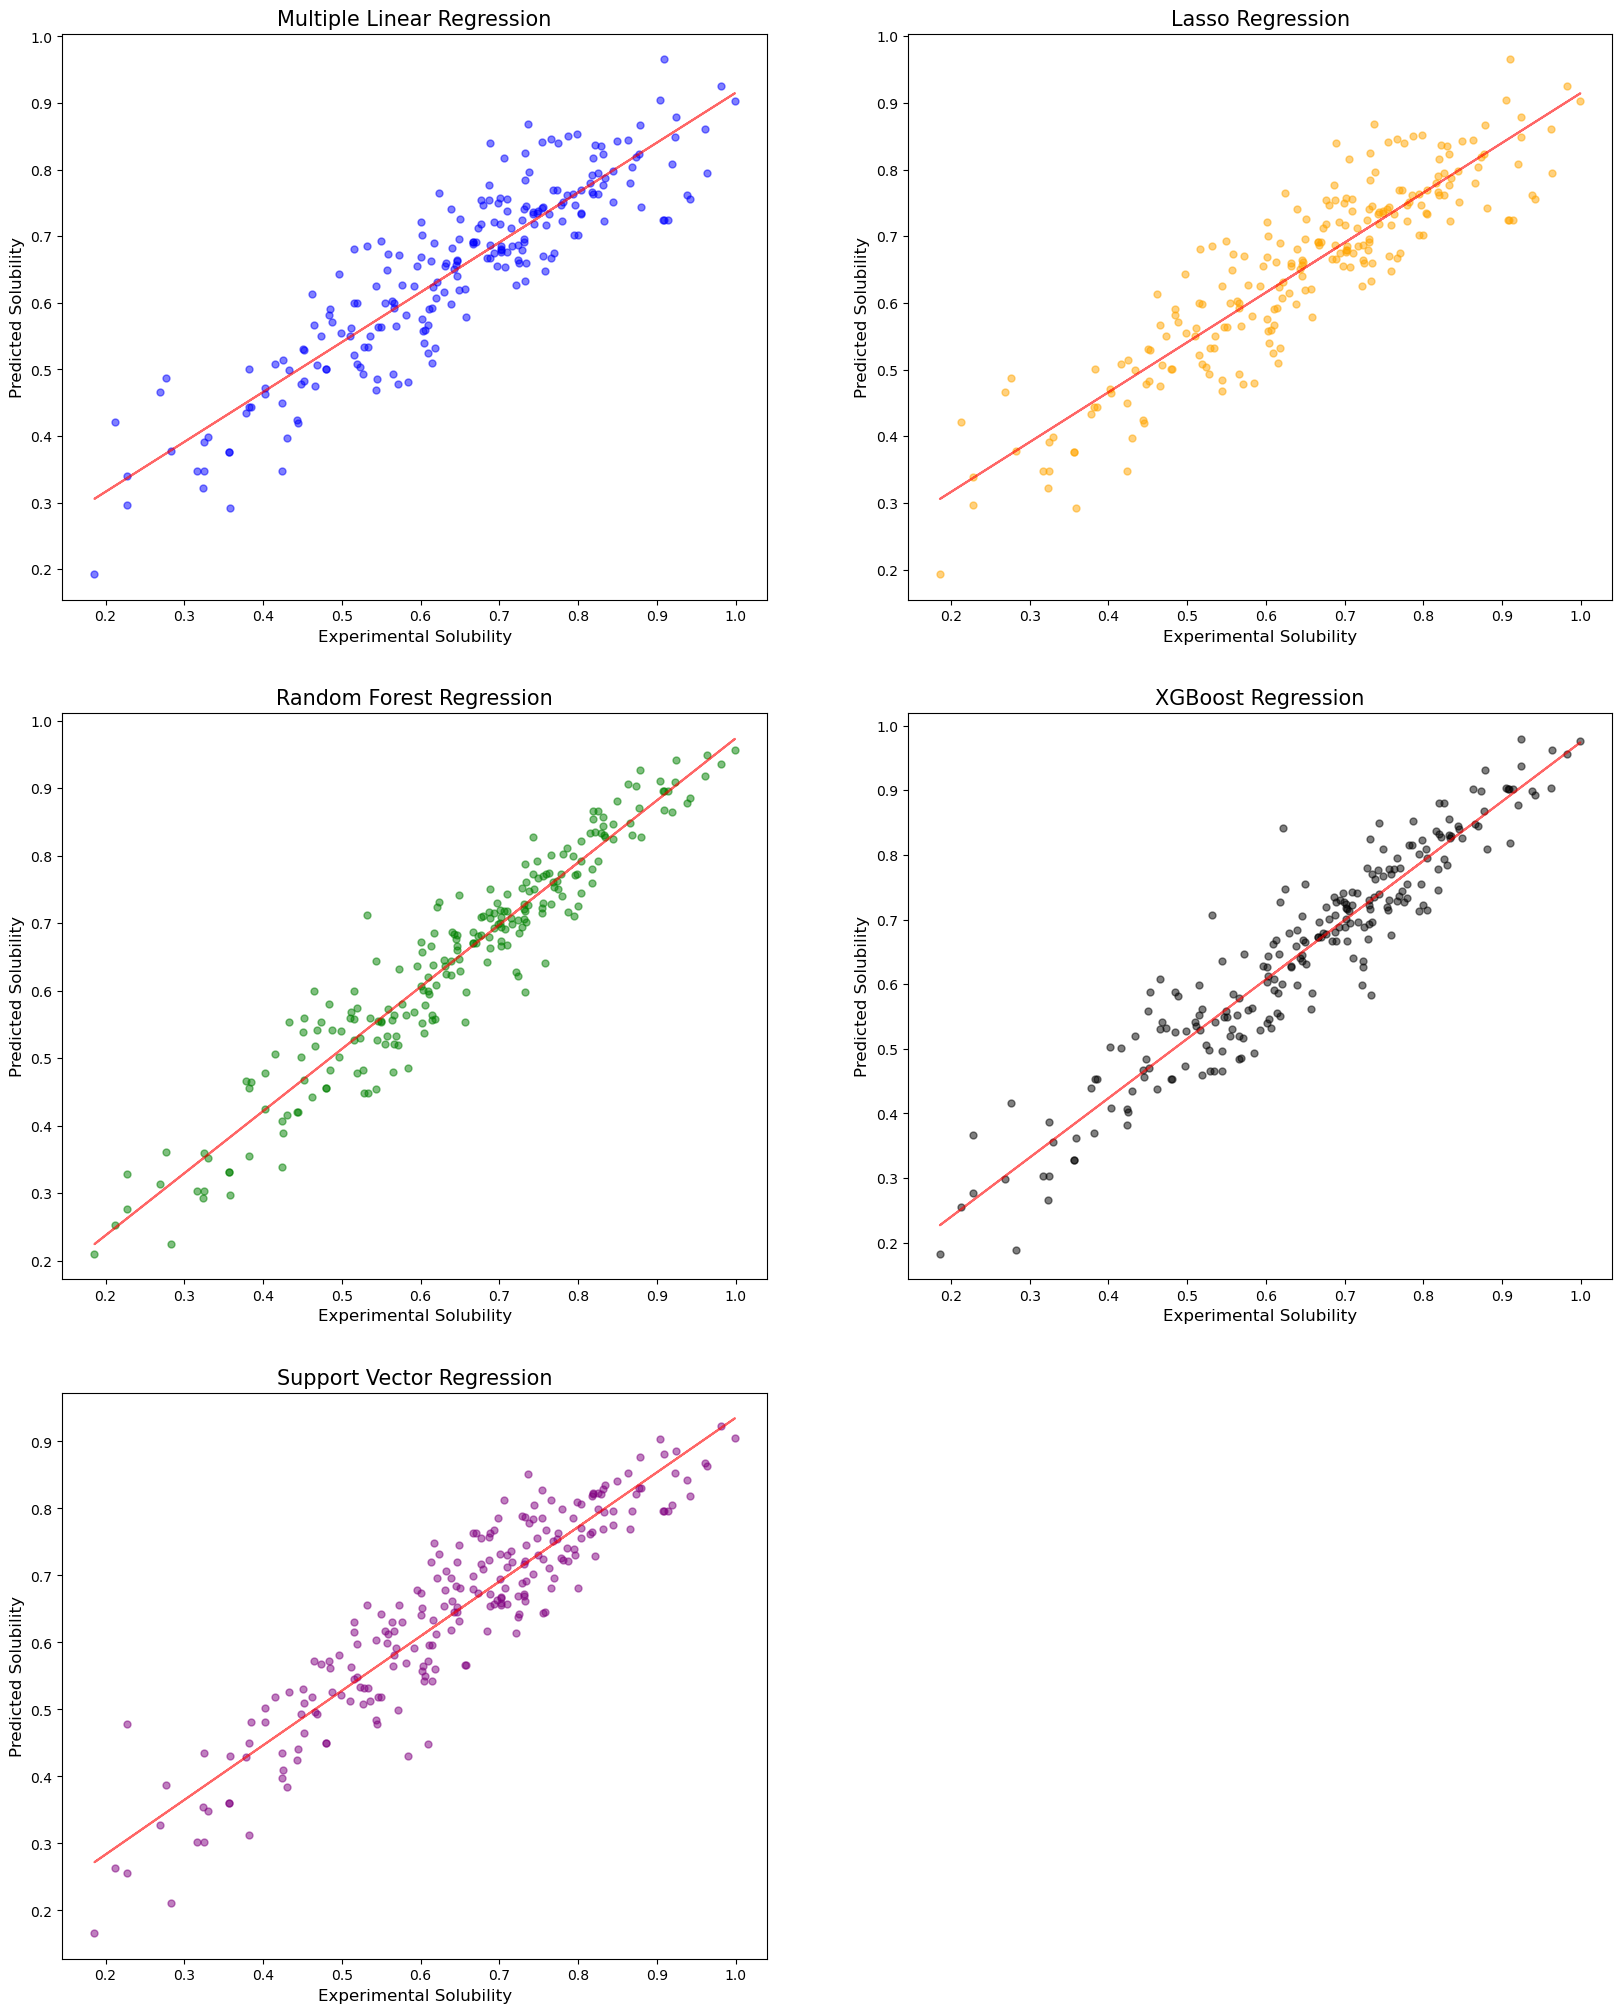

In [49]:
plt.figure(figsize=(20,25))
plt.subplot(3,2,1)
slope_lin, intercept_lin = np.polyfit(Y_test, Y_pred_test_lr, 1)
plt.scatter(x=Y_test, y=Y_pred_test_lr,color = 'blue',s = 25, alpha = 0.5)
plt.plot(Y_test, slope_lin*Y_test+ intercept_lin, color='red', alpha = 0.6)
plt.xlabel('Experimental Solubility',fontdict={'fontsize':12})
plt.ylabel('Predicted Solubility',fontdict={'fontsize':12})
plt.title('Multiple Linear Regression', fontdict={'fontsize':15})


plt.subplot(3,2,2)
slope_las, intercept_las = np.polyfit(Y_test, Y_pred_lasso, 1)
plt.scatter(x=Y_test, y=Y_pred_lasso,color = 'orange',s = 25, alpha = 0.5)
plt.plot(Y_test, slope_las*Y_test+ intercept_las, color='red', alpha = 0.6)
plt.xlabel('Experimental Solubility',fontdict={'fontsize':12})
plt.ylabel('Predicted Solubility',fontdict={'fontsize':12})
plt.title('Lasso Regression', fontdict={'fontsize':15})

plt.subplot(3,2,3)
slope_rf, intercept_rf = np.polyfit(Y_test, Y_pred_rf_reg, 1)
plt.scatter(x=Y_test, y=Y_pred_rf_reg,color = 'green',s = 25, alpha = 0.5)
plt.plot(Y_test, slope_rf*Y_test+ intercept_rf, color='red', alpha = 0.6)
plt.xlabel('Experimental Solubility',fontdict={'fontsize':12})
plt.ylabel('Predicted Solubility',fontdict={'fontsize':12})
plt.title('Random Forest Regression', fontdict={'fontsize':15})

plt.subplot(3,2,4)
slope_xg, intercept_xg = np.polyfit(Y_test, Y_pred_xg, 1)
plt.scatter(x=Y_test, y=Y_pred_xg,color = 'black',s = 25, alpha = 0.5)
plt.plot(Y_test, slope_xg*Y_test+ intercept_xg, color='red', alpha = 0.6)
plt.xlabel('Experimental Solubility',fontdict={'fontsize':12})
plt.ylabel('Predicted Solubility',fontdict={'fontsize':12})
plt.title('XGBoost Regression', fontdict={'fontsize':15})

plt.subplot(3,2,5)
slope_sv, intercept_sv = np.polyfit(Y_test, Y_pred_svr, 1)
plt.scatter(x=Y_test, y=Y_pred_svr,color = 'purple',s = 25, alpha = 0.5)
plt.plot(Y_test, slope_sv*Y_test+ intercept_sv, color='red', alpha = 0.6)
plt.xlabel('Experimental Solubility',fontdict={'fontsize':12})
plt.ylabel('Predicted Solubility',fontdict={'fontsize':12})
plt.title('Support Vector Regression', fontdict={'fontsize':15})

plt.show()